# Notebook lecture 3: State Feedback for CS2
&copy; 2025 ETH Zurich, Joël Gmür, Joël Lauper, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Authors:
- Joël Gmür; jgmuer@ethz.ch
- Joël Lauper; jlauper@ethz.ch

To start, run the following cell to install the necessary modules and import the libraries.

In [69]:
# Import the required python libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.signal as signal
import ipywidgets as widgets
from ipywidgets import interactive


## Problem Setup

In this Notebook we will use a simple mass-spring-damper system. The state space description of the linear system reads (if we care about position as an output and $\frac{k}{m} = \frac{c}{m} = 1$ and $u=\frac{F(t)}{m}$):

$$
\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =\begin{bmatrix}\dot{x} \\ \ddot{x} \end{bmatrix} = \begin{bmatrix}0 & 1 \\ -1 & -1 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix} + \begin{bmatrix}0 \\ 1 \end{bmatrix} u,
$$

$$y = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}. $$

In [99]:
# Define the state-space system (mass-spring-damper)
A = np.array([[0, 1],
              [-1, -1]])  # System dynamics 
B = np.array([[0], [1]])  # Input matrix
C = np.array([[1, 0]])    # Output matrix (we care about position)
D = np.array([[0]])   

## Exercise 1: Pole placement

Using state-feedback, it is now possible to place the poles wherever see fit. Using Ackermann's formula we can directly find a state-feedback controller that places the closed-loop poles at the desired position. For a 2x2 $A$ matrix, Ackermann's formula reads as:

$$ K = [0  \ 1] \cdot \mathcal{R}^{-1} \cdot \phi_d(A), $$

where $\mathcal{R}$ is the reachability matrix and $\phi_d$ is the desired characteristic polynomial. In the following code snippet we will define the poles p1 and p2.

In [ ]:
I = np.identity(2)

# Function to update the plot based on pole positions
def update_step_response(p1, p2):
    # Compute reachability matrix
    R = np.hstack([B, A @ B])
    
    # Compute characteristic polynomial
    phi_d = (A - I * p1) @ (A - I * p2)
    
    # Evaluate state-feedback matrix
    K = np.array([[0, 1]]) @ np.linalg.inv(R) @ phi_d

    # Find the closed-loop matrix
    A_cl = A - B @ K    

    if(np.linalg.matrix_rank(A_cl) != 2):
        print("error: singular closed loop matrix!")

    # Compute reference scaling factor
    Kr = np.linalg.inv(-C @ np.linalg.inv(A_cl) @ B)
    
    # Create state-space system
    system = signal.StateSpace(A_cl, B @ Kr, C, D)
    
    # Simulating step response
    t = np.linspace(0, 10, 1000)  # Time vector from 0 to 10 sec
    r = np.ones_like(t)  # Step input
    x0 = np.array([0, 0])  # Initial state

    t_out, y, x = signal.lsim(system, U=r, T=t, X0=x0)
    
    # Compute input
    u = -K @ x.T + Kr * r
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
   
    axs[0].plot(t, y, label="Step Response", color="b")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Response")
    axs[0].set_title("Closed-Loop Step Response")
    axs[0].grid()
    axs[0].legend()
    
    axs[1].plot(t, u.T, label="Control Input", color="r")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Input u")
    axs[1].set_title("Control Input to System")
    axs[1].grid()
    axs[1].legend()
    axs[1].set_ylim([-10, 100])
    
    plt.show()

interactive_plot = interactive(update_step_response, 
                               p1=widgets.FloatSlider(min=-10, max=1, step=1, value=-70, description="p1"),
                               p2=widgets.FloatSlider(min=-10, max=1, step=1, value=-10, description="p2"))

interactive_plot

interactive(children=(FloatSlider(value=-10.0, description='p1', max=1.0, min=-10.0, step=1.0), FloatSlider(va…

Note that we can make the response faster by choosing poles that are further left in the complex plane. But this also means that we need a more extreme control input! We could experiment with setting the poles and find a good trade-off, but a better way is using a mathematical method that automatically sets the optimal poles accorind to criteria we set. This concept will be explored in Exercise 2.

## Exercise 2: LQR

When doing state feedback control, there is some sort of tradeoff between control performance and expended input energy. One way to design a controller that takes this into account when choosing control action is to quantify the tradeoff in a cost function. The resulting control problem is solved by the $\textbf{Linear Quadratic Regulator (LQR)}.$ We define a cost function in order to solve this problem:
$$J = \int_0^{\infty}u^TRu + x^TQx\;dt .$$  
Here $u$ is the input of the system, $x$ is the state of the system and $R, Q$ are the weight matrices. Our goal is to find a controller that minimizes the cost function $J$. Such a controller is called optimal. We choose the entries of the weighting matrices according to what we want to "punish" more, bad performance or high energy expenditure.  


### 2.2. LQR controller gain
Now we write a function to compute the LQR controller gain by solving the continuous-time algebraic Riccati equation: 

The continuous-time algebraic Riccati Equation is given by:

$$
A^T P + P A - P B R^{-1} B^T P + Q = 0
$$

The LQR controller gain is computed using: 

$$
K = R^{-1} * B^T * P
$$

In [8]:
# Function to compute the LQR controller gain
def compute_lqr(A, B, Q, R):
    # Solve the continuous-time algebraic Riccati equation (CARE)
    P = linalg.solve_continuous_are(A, B, Q, R)
    # Compute the LQR controller gain (K = inv(R) * B' * P)
    K = np.linalg.inv(R) @ B.T @ P
    return K

### 2.3. System step response for different values of Q and R
In a third step, we simulate the step response of our system using different values of $Q$ and $R$.

Remember: $Q$ punishes the state error while $R$ punishes a high input.

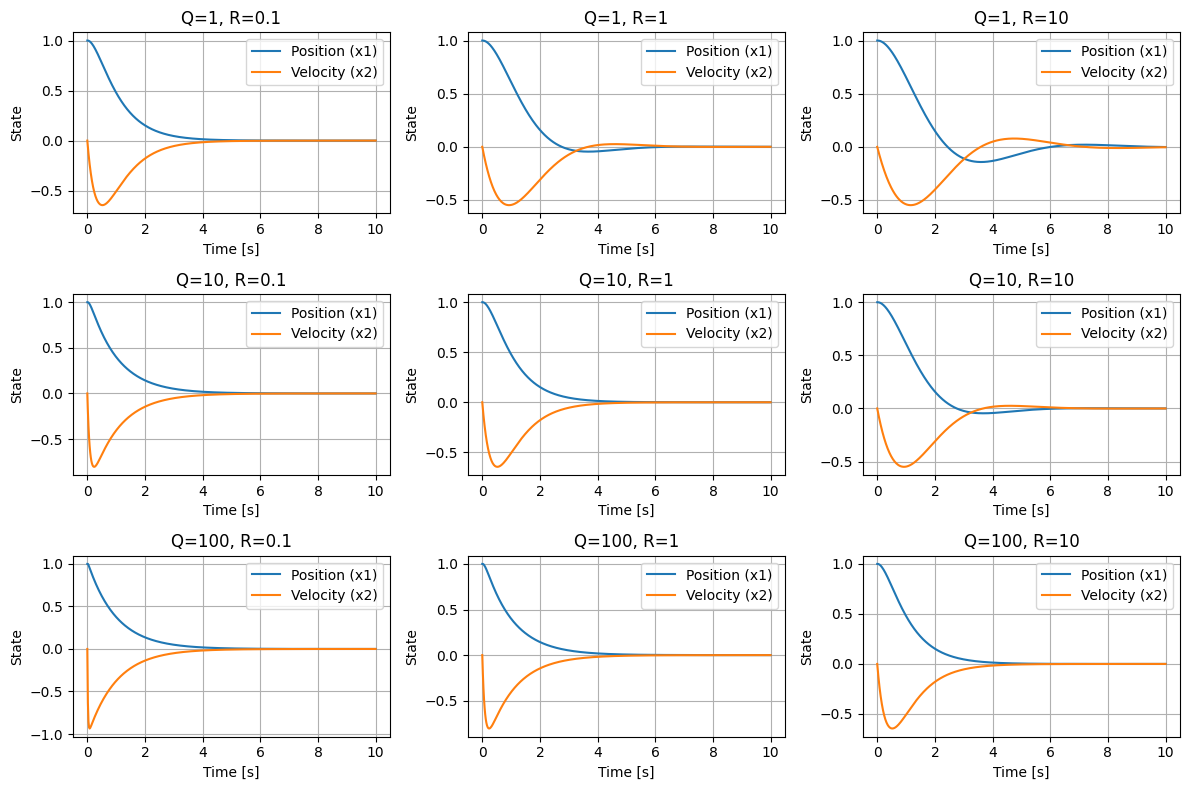

In [9]:
# Function to simulate the closed-loop system
def simulate_system(A, B, C, K, time_end=10, initial_state=[1, 0]):
    # Closed-loop system dynamics (A_cl = A - B*K)
    A_cl = A - B @ K
    
    # Time vector
    t = np.linspace(0, time_end, 500)
    
    # Simulate the system's response to the initial state
    x = np.zeros((len(t), len(initial_state)))
    x[0] = initial_state
    
    for i in range(1, len(t)):
        # State update: x_dot = A_cl * x
        x_dot = A_cl @ x[i-1]
        x[i] = x[i-1] + x_dot * (t[i] - t[i-1])  # Simple Euler integration
    
    # Plot the system's state over time
    plt.plot(t, x[:, 0], label='Position (x1)')
    plt.plot(t, x[:, 1], label='Velocity (x2)')
    plt.xlabel('Time [s]')
    plt.ylabel('State')
    plt.title('Closed-Loop System Response with LQR Control')
    plt.legend()
    plt.grid(True)

# Define different values for Q and R weights to compare
Q_values = [1, 10, 100]  # Different state error weights (Q)
R_values = [0.1, 1, 10]  # Different input weights (R)

# Set up the plot
plt.figure(figsize=(12, 8))

# Loop over combinations of Q and R
for Q_val in Q_values:
    for R_val in R_values:
        # Define Q and R
        Q = np.diag([Q_val, Q_val])  # State error weight
        R = np.array([[R_val]])      # Input weight
        
        # Compute the LQR gain K
        K = compute_lqr(A, B, Q, R)
        
        # Simulate and plot the closed-loop system
        plt.subplot(len(Q_values), len(R_values), len(R_values)*(Q_values.index(Q_val)) + R_values.index(R_val) + 1)
        simulate_system(A, B, C, K, time_end=10)
        plt.title(f"Q={Q_val}, R={R_val}")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()